## Data Preparation

This section loads the dataset and encodes the actions using LabelEncoder.


In [63]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
file_path = 'input_game.csv'
data = pd.read_csv(file_path)

# Create another dataframe with p1 and p2 swapped
swapped_data = data.copy()
swapped_data = swapped_data.rename(columns={'p1_id': 'p2_id', 'p2_id': 'p1_id', 'p1_action': 'p2_action', 'p2_action': 'p1_action'})
swapped_data['game_id'] = swapped_data['game_id'] + len(data)

# Combine original and swapped data
data = pd.concat([data, swapped_data], ignore_index=True)
# This is because i will determine strategies wrt to player 1

data.head()


,game_id,p1_id,p2_id,p1_action,p2_action,turn
0,0,174,125,TRUST,CHEAT,1
1,0,174,125,CHEAT,TRUST,2
2,0,174,125,TRUST,TRUST,3
3,0,174,125,TRUST,TRUST,4
4,0,174,125,TRUST,TRUST,5


In [87]:
# Helper function to create features based on past actions
def create_features(df):
    df['p1_last_action'] = df.groupby(['game_id', 'p1_id'])['p1_action'].shift(1)
    df['p2_last_action'] = df.groupby(['game_id', 'p2_id'])['p2_action'].shift(1)
    df['p1_last_2_action'] = df.groupby(['game_id', 'p1_id'])['p1_action'].shift(2)
    df['p2_last_2_action'] = df.groupby(['game_id', 'p2_id'])['p2_action'].shift(2)
    df = df.fillna('NONE')  # Fill NaN values for initial rounds
    return df

# Apply the feature creation
data = create_features(data)

data.head()


,game_id,p1_id,p2_id,p1_action,p2_action,turn,p1_action_encoded,p2_action_encoded,p1_last_action,p2_last_action,p1_last_2_action,p2_last_2_action
0,0,174,125,TRUST,CHEAT,1,1,0,NONE,NONE,NONE,NONE
1,0,174,125,CHEAT,TRUST,2,0,1,TRUST,CHEAT,NONE,NONE
2,0,174,125,TRUST,TRUST,3,1,1,CHEAT,TRUST,TRUST,CHEAT
3,0,174,125,TRUST,TRUST,4,1,1,TRUST,TRUST,CHEAT,TRUST
4,0,174,125,TRUST,TRUST,5,1,1,TRUST,TRUST,TRUST,TRUST


## Feature Creation

This section creates features for all previous actions for both players.


In [89]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

# Encode the actions to numerical values
le = LabelEncoder()
data['p1_action_encoded'] = le.fit_transform(data['p1_action'])
data['p2_action_encoded'] = le.fit_transform(data['p2_action'])
data['p1_last_action_encoded'] = le.fit_transform(data['p1_last_action'])
data['p2_last_action_encoded'] = le.fit_transform(data['p2_last_action'])
data['p1_last_2_action_encoded'] = le.fit_transform(data['p1_last_2_action'])
data['p2_last_2_action_encoded'] = le.fit_transform(data['p2_last_2_action'])

def aggregate_encoded_action_features_with_opponents(df):
    p1_agg = df.groupby('p1_id').agg({
        'p1_action_encoded': 'mean',
        'p1_last_action_encoded': 'mean',
        'p1_last_2_action_encoded': 'mean',
        'p2_action_encoded': 'mean',
        'p2_last_action_encoded': 'mean',
        'p2_last_2_action_encoded': 'mean'
    }).rename(columns=lambda x: x.replace('p1_', '').replace('p2_', 'opp_'))

    p1_agg.index.name = 'player_id'

    combined_agg = p1_agg.groupby('player_id').mean().reset_index()

    return combined_agg

data_df = aggregate_encoded_action_features_with_opponents(data)

features = [
    'action_encoded', 'last_action_encoded', 'last_2_action_encoded',
    'opp_action_encoded', 'opp_last_action_encoded', 'opp_last_2_action_encoded'
]

data_df.head()

,player_id,action_encoded,last_action_encoded,last_2_action_encoded,opp_action_encoded,opp_last_action_encoded,opp_last_2_action_encoded
0,1,0.550125,1.100249,1.099252,0.543142,1.086284,1.086284
1,2,0.766629,1.521984,1.510710,0.648253,1.296505,1.289741
2,3,0.760432,1.510064,1.501227,0.668630,1.333333,1.327442
3,4,0.043557,0.104658,0.120992,0.414398,0.830611,0.834846
4,5,0.542312,1.083075,1.082559,0.441176,0.882869,0.882353


## Clustering

This section performs KMeans clustering on the aggregated strategy features to assign each player to a cluster.


In [54]:
import matplotlib.pyplot as plt

# Function to calculate and plot WCSS for a given dataset and feature set
def plot_elbow_method(data, features, cluster_range, title):
    wcss = []
    for i in cluster_range:
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(data[features])
        wcss.append(kmeans.inertia_)

    # Plot the WCSS values
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, wcss, marker='o')
    plt.title(f'Elbow Method For Optimal Number of Clusters ({title})')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.xticks(cluster_range)
    plt.grid(True)
    plt.show()

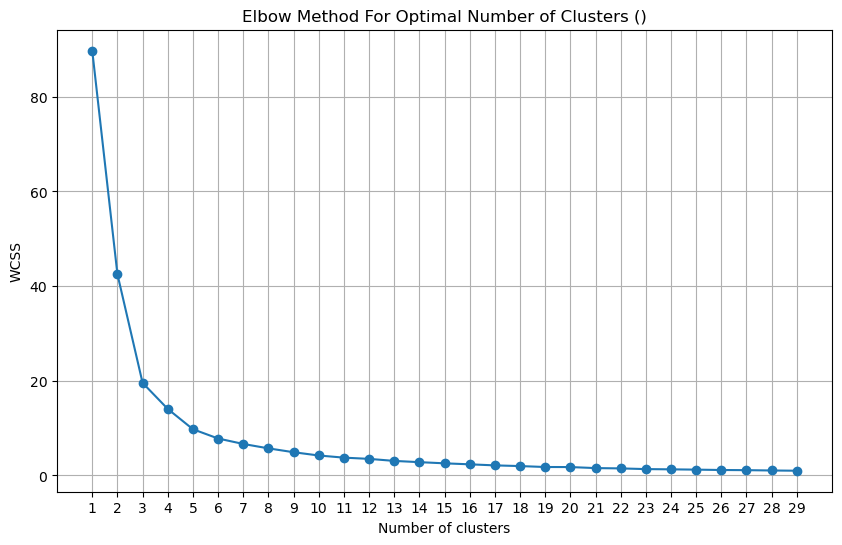

In [90]:
plot_elbow_method(data_df, features, range(1, 30), '')


In [82]:
# Helper function to encode actions to numerical values
def encode_actions(df):
    le = LabelEncoder()
    df['p1_action'] = le.fit_transform(df['p1_action'])
    df['p2_action'] = le.fit_transform(df['p2_action'])
    return df

# Helper function to create advanced features based on past actions
def create_advanced_features(df):
    df['p1_last_1_action'] = df.groupby(['game_id', 'p1_id'])['p1_action'].shift(1)
    df['p2_last_1_action'] = df.groupby(['game_id', 'p2_id'])['p2_action'].shift(1)
    df['p1_last_2_action'] = df.groupby(['game_id', 'p1_id'])['p1_action'].shift(2)
    df['p2_last_2_action'] = df.groupby(['game_id', 'p2_id'])['p2_action'].shift(2)
    df['p1_last_3_action'] = df.groupby(['game_id', 'p1_id'])['p1_action'].shift(3)
    df['p2_last_3_action'] = df.groupby(['game_id', 'p2_id'])['p2_action'].shift(3)
    
    # Calculate action ratios
    df['p1_trust_ratio'] = df.groupby(['game_id', 'p1_id'])['p1_action'].rolling(4).mean().reset_index(level=[0, 1], drop=True)
    df['p2_trust_ratio'] = df.groupby(['game_id', 'p2_id'])['p2_action'].rolling(4).mean().reset_index(level=[0, 1], drop=True)
    
    df = df.fillna(-1)  # Fill NaN values for initial rounds with a distinct value
    return df

# Encode actions before creating advanced features
data_encoded = encode_actions(data.copy())

# Apply the advanced feature creation
data_advanced = create_advanced_features(data_encoded)

def aggregate_advanced_features_with_opponents(df):
    p1_agg = df.groupby('p1_id').agg({
        'p1_action': 'mean',
        'p1_last_1_action': 'mean',
        'p1_last_2_action': 'mean',
        'p1_last_3_action': 'mean',
        'p1_trust_ratio': 'mean',
        'p2_action': 'mean',
        'p2_last_1_action': 'mean',
        'p2_last_2_action': 'mean',
        'p2_last_3_action': 'mean',
        'p2_trust_ratio': 'mean'
    }).rename(columns=lambda x: x.replace('p1_', '').replace('p2_', 'opp_'))

    p1_agg.index.name = 'player_id'

    combined_agg = p1_agg.groupby('player_id').mean().reset_index()

    return combined_agg

aggregated_advanced_features = aggregate_advanced_features_with_opponents(data_advanced)

# Select features for clustering
advanced_features = [
    'action', 'last_1_action', 'last_2_action', 'last_3_action', 'trust_ratio',
    'opp_action', 'opp_last_1_action', 'opp_last_2_action', 'opp_last_3_action', 'opp_trust_ratio'
]

aggregated_advanced_features.head()



,player_id,action,last_1_action,last_2_action,last_3_action,trust_ratio,opp_action,opp_last_1_action,opp_last_2_action,opp_last_3_action,opp_trust_ratio
0,1,0.550125,0.526185,0.501746,0.477307,0.481671,0.543142,0.519202,0.495262,0.469825,0.468454
1,2,0.766629,0.735626,0.704622,0.675310,0.672210,0.648253,0.622886,0.594138,0.565389,0.565671
2,3,0.760432,0.731468,0.703486,0.676485,0.672680,0.668630,0.643103,0.616593,0.589593,0.588979
3,4,0.043557,0.026013,0.007864,-0.010284,-0.010738,0.414398,0.388990,0.364791,0.338173,0.337266
4,5,0.542312,0.517544,0.493292,0.469556,0.473555,0.441176,0.417441,0.393189,0.369453,0.368034


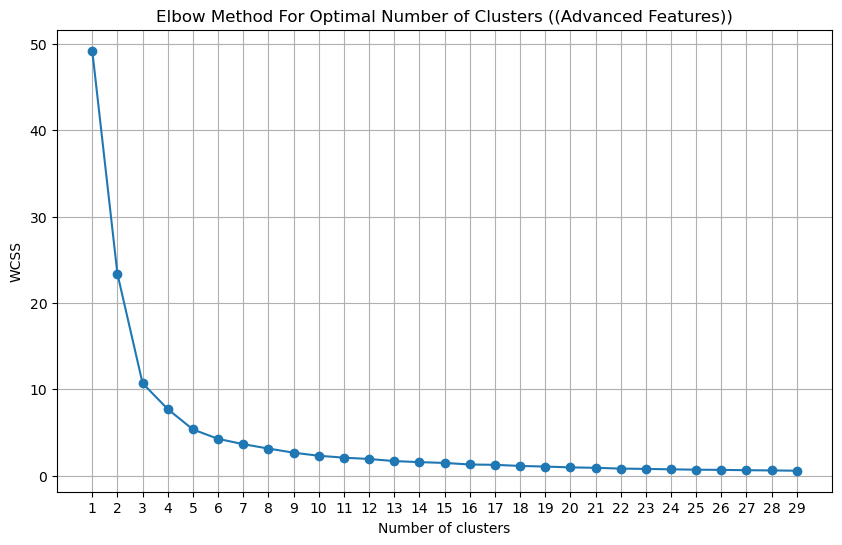

In [83]:
plot_elbow_method(aggregated_advanced_features, advanced_features, range(1, 30), '(Advanced Features)')


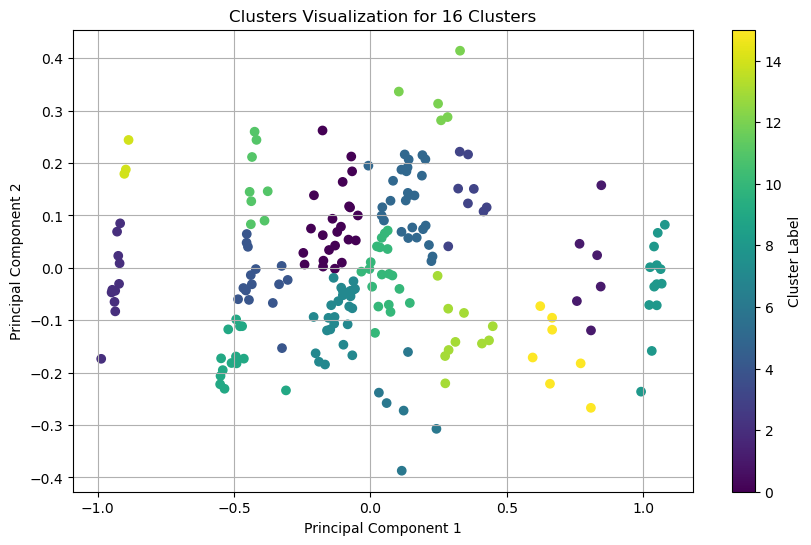

In [84]:
from sklearn.decomposition import PCA

# Function to plot clusters
def plot_clusters(n_clusters,data_advanced,features):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(data_advanced[features])

    # Reduce dimensionality for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data_advanced[features])
    
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis')
    plt.title(f'Clusters Visualization for {n_clusters} Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster Label')
    plt.grid(True)
    plt.show()

# Specify the number of clusters for visualization
n_clusters = 16  

# Plot the clusters
plot_clusters(n_clusters, aggregated_advanced_features, advanced_features)

Adding features to capture different strategies

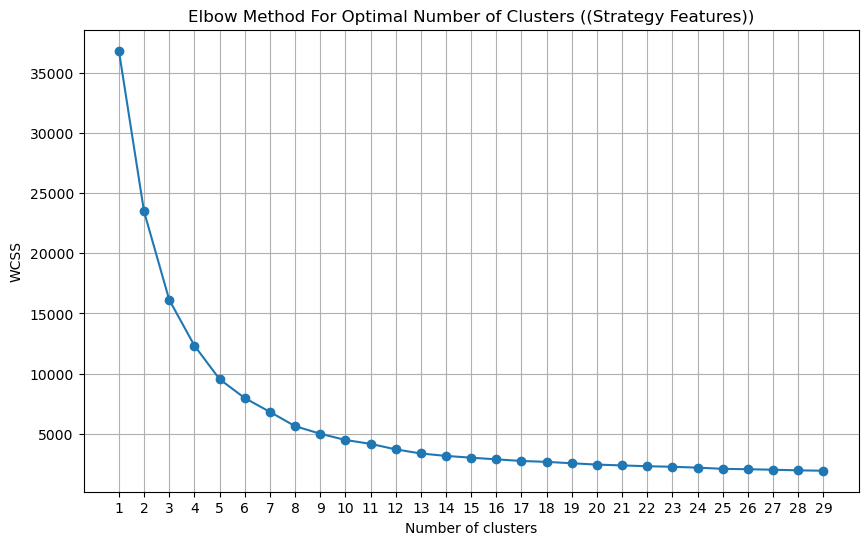

In [74]:
# Function to create strategy features
def create_strategy_features(df):
    # Create and fit a single LabelEncoder instance on all action labels
    le = LabelEncoder()
    all_actions = pd.concat([df['p1_action'], df['p2_action']])
    le.fit(all_actions.unique())

    # Encode actions to numerical values
    df['p1_action_encoded'] = le.transform(df['p1_action'])
    df['p2_action_encoded'] = le.transform(df['p2_action'])

    # Initial Moves
    df['p1_initial_moves'] = df.groupby(['game_id', 'p1_id'])['p1_action_encoded'].transform(lambda x: ''.join(x.astype(str).values[:4]))
    df['p2_initial_moves'] = df.groupby(['game_id', 'p2_id'])['p2_action_encoded'].transform(lambda x: ''.join(x.astype(str).values[:4]))

    # Encode initial moves using a new LabelEncoder to avoid the previously seen issues
    le_initial_moves = LabelEncoder()
    df['p1_initial_moves_encoded'] = le_initial_moves.fit_transform(df['p1_initial_moves'])
    df['p2_initial_moves_encoded'] = le_initial_moves.fit_transform(df['p2_initial_moves'])
    
    # Reaction to Opponent's Moves
    df['p1_reaction'] = df['p1_action_encoded'] - df['p2_action_encoded'].shift(1)
    df['p2_reaction'] = df['p2_action_encoded'] - df['p1_action_encoded'].shift(1)
    
    # Consistency
    df['p1_consistency'] = df.groupby(['game_id', 'p1_id'])['p1_action_encoded'].transform(lambda x: (x == x.shift(1)).astype(int).cumsum())
    df['p2_consistency'] = df.groupby(['game_id', 'p2_id'])['p2_action_encoded'].transform(lambda x: (x == x.shift(1)).astype(int).cumsum())
    
    # Forgiveness and Retaliation
    trust_encoded = le.transform(['TRUST'])[0]
    cheat_encoded = le.transform(['CHEAT'])[0]
    df['p1_forgiveness'] = df.groupby(['game_id', 'p1_id'])['p1_action_encoded'].transform(lambda x: (x.shift(-1) == trust_encoded).astype(int).cumsum())
    df['p2_forgiveness'] = df.groupby(['game_id', 'p2_id'])['p2_action_encoded'].transform(lambda x: (x.shift(-1) == trust_encoded).astype(int).cumsum())
    df['p1_retaliation'] = df.groupby(['game_id', 'p1_id'])['p1_action_encoded'].transform(lambda x: (x.shift(-1) == cheat_encoded).astype(int).cumsum())
    df['p2_retaliation'] = df.groupby(['game_id', 'p2_id'])['p2_action_encoded'].transform(lambda x: (x.shift(-1) == cheat_encoded).astype(int).cumsum())
    
    # Randomness
    df['p1_randomness'] = df.groupby(['game_id', 'p1_id'])['p1_action_encoded'].transform(lambda x: (x != x.shift(1)).astype(int).cumsum())
    df['p2_randomness'] = df.groupby(['game_id', 'p2_id'])['p2_action_encoded'].transform(lambda x: (x != x.shift(1)).astype(int).cumsum())
    
    df = df.fillna(-1)  
    return df

# Function to aggregate features by player ID, including opponent features
def aggregate_features_with_opponents(df):
    p1_agg = df.groupby('p1_id').agg({
        'p1_initial_moves_encoded': 'mean',
        'p1_reaction': 'mean',
        'p1_consistency': 'mean',
        'p1_forgiveness': 'mean',
        'p1_retaliation': 'mean',
        'p1_randomness': 'mean',
        'p2_initial_moves_encoded': 'mean',
        'p2_reaction': 'mean',
        'p2_consistency': 'mean',
        'p2_forgiveness': 'mean',
        'p2_retaliation': 'mean',
        'p2_randomness': 'mean'
    }).rename(columns=lambda x: x.replace('p1_', '').replace('p2_', 'opp_'))

    p1_agg.index.name = 'player_id'

    combined_agg = p1_agg.groupby('player_id').mean().reset_index()

    return combined_agg

# Apply strategy feature creation
new_features_df = create_strategy_features(data.copy())

# Aggregate features by player ID, including opponent features
aggregated_features = aggregate_features_with_opponents(new_features_df)

# Select features for clustering
strategy_features = [
    'initial_moves_encoded', 'reaction', 'consistency', 'forgiveness', 'retaliation', 'randomness',
    'opp_initial_moves_encoded', 'opp_reaction', 'opp_consistency', 'opp_forgiveness', 'opp_retaliation', 'opp_randomness'
]

plot_elbow_method(aggregated_features,strategy_features,range(1, 30), '(Strategy Features)')

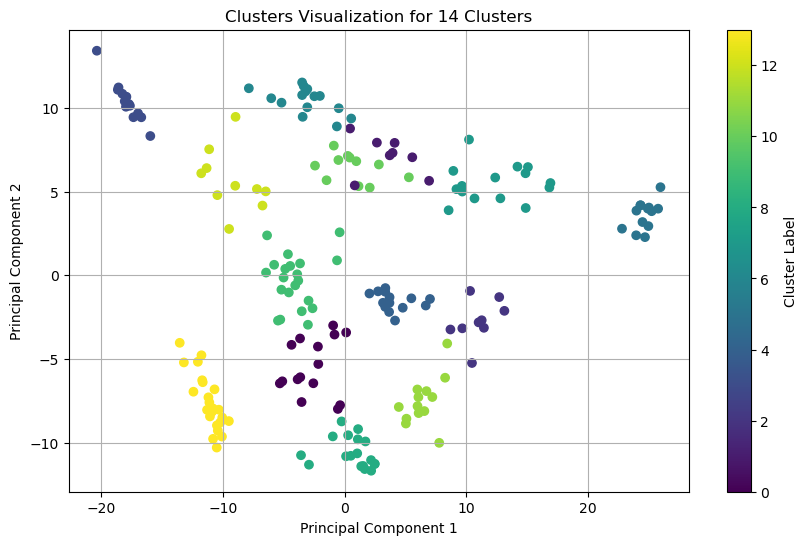

In [75]:
plot_clusters(14,aggregated_features,strategy_features)

In [77]:
# Function to perform clustering and extract clusters by player ID
def extract_clusters_by_player_id(data, features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    data['cluster'] = kmeans.fit_predict(data[features])
    player_clusters = data[['player_id', 'cluster']].drop_duplicates()
    return player_clusters

player_cluster = extract_clusters_by_player_id(aggregated_features, strategy_features, 14)

In [78]:
player_cluster.head(50)

,player_id,cluster
0,1,10
1,2,12
2,3,12
3,4,5
4,5,10
5,6,13
6,7,10
7,8,13
8,9,3
9,10,4


### Training RandomForestClassifier model for each strategy

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       0.78      0.88      0.82         8
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      0.50      0.67         4
          13       1.00      1.00      1.00         6

    accuracy                           0.93        41
   macro avg       0.96      0.94      0.94        41
weighted avg       0.94      0.93      0.92        41



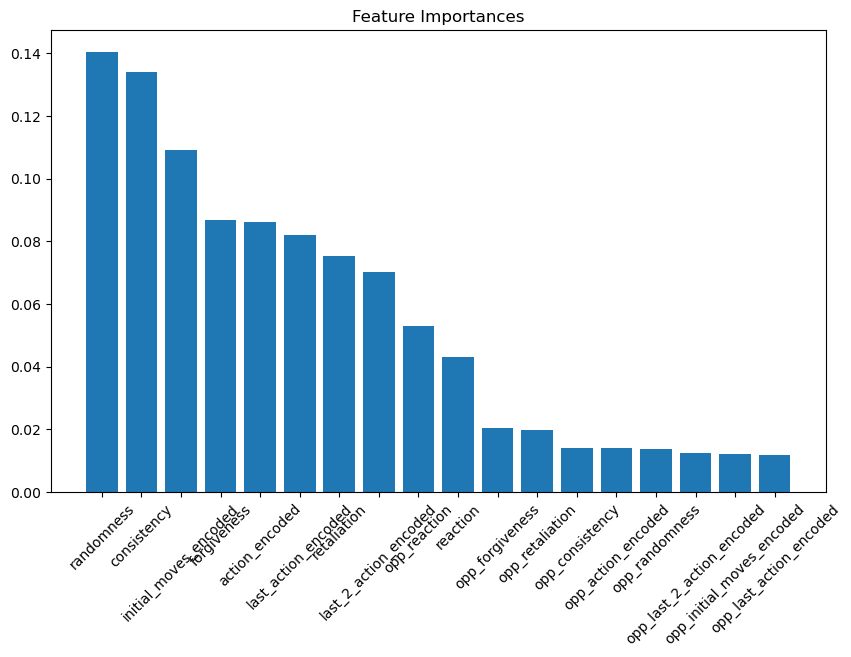

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Merge both aggregated features
merged_features = pd.merge(data_df, aggregated_features, on='player_id')

# Select combined features for clustering
combined_features = [
    'action_encoded', 'last_action_encoded', 'last_2_action_encoded',
    'opp_action_encoded', 'opp_last_action_encoded', 'opp_last_2_action_encoded',
    'initial_moves_encoded', 'reaction', 'consistency', 'forgiveness', 'retaliation', 'randomness',
    'opp_initial_moves_encoded', 'opp_reaction', 'opp_consistency', 'opp_forgiveness', 'opp_retaliation', 'opp_randomness'
]

train_data, test_data = train_test_split(merged_features, test_size=0.2, random_state=42)

# Define features and target for training
train_features = combined_features
target = 'cluster'

# Train a RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_data[train_features], train_data[target])

# Predict on the test set
test_data['predicted_cluster'] = rf_model.predict(test_data[train_features])

# Evaluate the model
print(classification_report(test_data[target], test_data['predicted_cluster']))

# Feature importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [train_features[i] for i in indices], rotation=45)
plt.show()

In [100]:
# Function to encode actions
def encode_actions(df):
    le = LabelEncoder()
    all_actions = pd.concat([df['p1_action'], df['p2_action']])
    le.fit(all_actions)
    
    df['p1_action_encoded'] = le.transform(df['p1_action'])
    df['p2_action_encoded'] = le.transform(df['p2_action'])
    return df, le

# Function to create features for all previous actions
def create_previous_action_features(df, history_length=10):
    for i in range(1, history_length + 1):
        df[f'p1_action_lag_{i}'] = df.groupby('p1_id')['p1_action_encoded'].shift(i)
        df[f'p2_action_lag_{i}'] = df.groupby('p2_id')['p2_action_encoded'].shift(i)
    
    df = df.fillna(-1)  
    return df

# Encode actions
data, le = encode_actions(data)

# Create features for all previous actions
history_length = 10  # Number of previous actions to consider
data = create_previous_action_features(data, history_length)
data.head()

,game_id,p1_id,p2_id,p1_action,p2_action,turn,p1_action_encoded,p2_action_encoded,p1_last_action,p2_last_action,...,p1_action_lag_6,p2_action_lag_6,p1_action_lag_7,p2_action_lag_7,p1_action_lag_8,p2_action_lag_8,p1_action_lag_9,p2_action_lag_9,p1_action_lag_10,p2_action_lag_10
0,0,174,125,TRUST,CHEAT,1,1,0,NONE,NONE,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0,174,125,CHEAT,TRUST,2,0,1,TRUST,CHEAT,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0,174,125,TRUST,TRUST,3,1,1,CHEAT,TRUST,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0,174,125,TRUST,TRUST,4,1,1,TRUST,TRUST,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0,174,125,TRUST,TRUST,5,1,1,TRUST,TRUST,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## Model Training for Each Cluster

This section trains separate RandomForest models for each cluster using all previous actions as features.


In [101]:
# Train separate RandomForest models for each cluster (strategy) using all previous actions as features
models = {}
for cluster in range(player_cluster['cluster'].nunique()):
    # Get player IDs for the current cluster
    player_ids = player_cluster[player_cluster['cluster'] == cluster]['player_id']
    
    # Get data for the current cluster
    cluster_data = data[data['p1_id'].isin(player_ids) | data['p2_id'].isin(player_ids)]
    
    # Prepare features and target
    features = [f'p1_action_lag_{i}' for i in range(1, history_length + 1)] + [f'p2_action_lag_{i}' for i in range(1, history_length + 1)]
    target = 'p1_action_encoded'
    
    # Remove rows with NaN values in features or target
    cluster_data = cluster_data.dropna(subset=features + [target])
    
    # Split the data into training and testing sets
    train_data, test_data = train_test_split(cluster_data, test_size=0.2, random_state=42)
    
    # Train a RandomForest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(train_data[features], train_data[target])
    
    # Save the model
    models[cluster] = rf_model
    
    # Predict on the test set
    test_data['predicted_action'] = rf_model.predict(test_data[features])
    
    # Evaluate the model
    print(f"Cluster {cluster} - Classification Report")
    print(classification_report(test_data[target], test_data['predicted_action']))

Cluster 0 - Classification Report
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4814
           1       0.87      0.88      0.88      5525

    accuracy                           0.87     10339
   macro avg       0.87      0.86      0.86     10339
weighted avg       0.87      0.87      0.87     10339

Cluster 1 - Classification Report
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2865
           1       0.88      0.89      0.88      2831

    accuracy                           0.88      5696
   macro avg       0.88      0.88      0.88      5696
weighted avg       0.88      0.88      0.88      5696

Cluster 2 - Classification Report
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      3618
           1       0.82      0.82      0.82      2344

    accuracy                           0.86      5962
   macro avg       0.85   

## Monte Carlo Simulation

This section implements the Monte Carlo simulation where each strategy plays against every other strategy.


In [102]:
reward_matrix = {
    ('Trust', 'Trust'): (2, 2),
    ('Trust', 'Cheat'): (-1, 3),
    ('Cheat', 'Trust'): (3, -1),
    ('Cheat', 'Cheat'): (0, 0)
}


In [111]:
import numpy as np

def simulate_game(strategy1, strategy2, model1, model2, num_rounds):
    actions = ['Trust', 'Cheat']
    le = LabelEncoder()
    le.fit(actions)
    
    p1_history = []
    p2_history = []
    p1_score, p2_score = 0, 0
    
    for round in range(num_rounds):
        if round == 0:
            p1_action = np.random.choice(actions)
            p2_action = np.random.choice(actions)
        else:
            p1_features = {f'p1_action_lag_{i}': le.transform([p1_history[-i]])[0] if i <= len(p1_history) else -1 for i in range(1, history_length + 1)}
            p1_features.update({f'p2_action_lag_{i}': le.transform([p2_history[-i]])[0] if i <= len(p2_history) else -1 for i in range(1, history_length + 1)})
            p2_features = {f'p1_action_lag_{i}': le.transform([p2_history[-i]])[0] if i <= len(p2_history) else -1 for i in range(1, history_length + 1)}
            p2_features.update({f'p2_action_lag_{i}': le.transform([p1_history[-i]])[0] if i <= len(p1_history) else -1 for i in range(1, history_length + 1)})
            
            p1_action = le.inverse_transform(model1.predict([list(p1_features.values())]))[0]
            p2_action = le.inverse_transform(model2.predict([list(p2_features.values())]))[0]
        
        p1_history.append(p1_action)
        p2_history.append(p2_action)
        
        p1_round_score, p2_round_score = reward_matrix[(p1_action, p2_action)]
        p1_score += p1_round_score
        p2_score += p2_round_score
    
    return p1_score, p2_score

def simulate_all_games(models, num_games=100, num_rounds=10):
    strategy_names = list(models.keys())
    scores = {strategy: 0 for strategy in strategy_names}
    
    for i, strategy1 in enumerate(strategy_names):
        for j, strategy2 in enumerate(strategy_names):
            if i <= j:  # Ensure each pair is played only once
                model1 = models[strategy1]
                model2 = models[strategy2]
                for _ in range(num_games):
                    p1_score, p2_score = simulate_game(strategy1, strategy2, model1, model2, num_rounds)
                    scores[strategy1] += p1_score
                    scores[strategy2] += p2_score
    
    return scores


In [118]:
# Simulate all games
num_games = 10
num_rounds = 5
strategy_scores = simulate_all_games(models, num_games, num_rounds)

# Calculate average scores
average_scores = {strategy: score / (num_games * (len(models) - 1)) for strategy, score in strategy_scores.items()}


## Strategy Ranking

This section ranks the strategies based on their average scores from the Monte Carlo simulation.


In [119]:
# Rank strategies based on average scores
ranked_strategies = sorted(average_scores.items(), key=lambda x: x[1], reverse=True)

# Print the ranking of strategies
print("Ranking of Strategies (from highest to lowest):")
for rank, (strategy, score) in enumerate(ranked_strategies, 1):
    print(f"{rank}. Strategy {strategy}: Average Score = {score:.2f}")


Ranking of Strategies (from highest to lowest):
1. Strategy 5: Average Score = 7.72
2. Strategy 7: Average Score = 7.50
3. Strategy 1: Average Score = 7.33
4. Strategy 2: Average Score = 7.24
5. Strategy 10: Average Score = 7.23
6. Strategy 3: Average Score = 7.20
7. Strategy 4: Average Score = 7.13
8. Strategy 11: Average Score = 6.89
9. Strategy 8: Average Score = 6.71
10. Strategy 13: Average Score = 6.66
11. Strategy 12: Average Score = 6.39
12. Strategy 0: Average Score = 6.20
13. Strategy 9: Average Score = 5.91
14. Strategy 6: Average Score = 5.62
